In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import stats, integrate, optimize
import random


In [2]:
# 関数の定義
def model_beta(x, alpha, beta):
    Np = 618
    # alphaとbetaは必ず正の値をとる
    if alpha <= 0 or beta <= 0:
        alpha, beta = 0.01, 0.01
    f = lambda a: (((a**(alpha-1)) * ((1-a)**(beta-1))) / random.betavariate(alpha, beta) ) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np)) )**(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [3]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [4]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [5]:
# left
active_node_list_left, edge_list_left, timestamp_left = return_nm(df_left)

In [6]:
max(active_node_list_left)

618

In [67]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta, xdata=edge_list_left, ydata=active_node_list_left, p0=[1, 1])

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  1.0804869626251776
beta:  0.995237195834311


In [68]:
Np = max(active_node_list_left)
alpha = params[0]
beta = params[1]

kappa = []
for i in range(len(edge_list_left)):
    kappa.append( (((alpha + beta)/alpha)**2) * ((2 * edge_list_left[i]) / (Np**2 - Np)) )

In [69]:
N_fit = []
for i in range(len(edge_list_left)):
    N_fit.append(model_beta([edge_list_left[i]], alpha, beta))

In [70]:
M_fit = []
for i in range(len(kappa)):
    M_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_7893/3845428671.py:8: RuntimeWarning: divide by zero encountered in power
  activity_list.append(((a**(alpha-1)) * ((1-a)**(beta-1))) / deno)


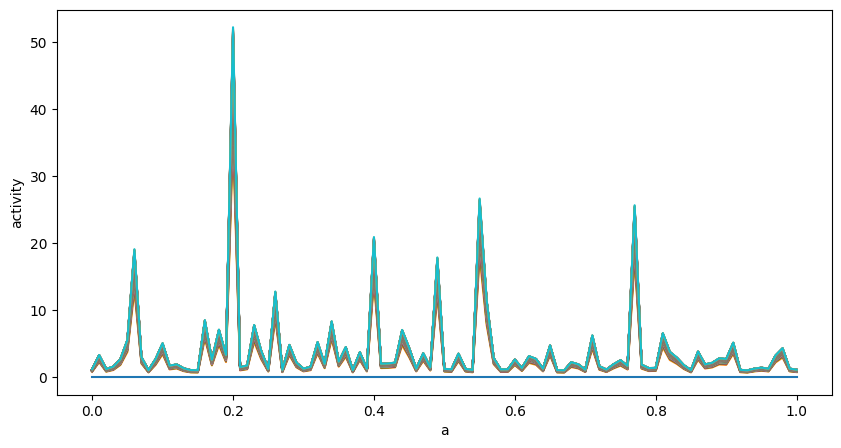

In [71]:
activity_list = []

a = np.linspace(0, 1, 101)
for i in range(len(a)):
    deno = random.betavariate(alpha, beta)
    if deno == 0:
        activity_list.append(0)
    activity_list.append(((a**(alpha-1)) * ((1-a)**(beta-1))) / deno)

# aとactivity_listのグラフ
plt.figure(figsize=(10, 5))
plt.plot(a, activity_list)
plt.xlabel('a')
plt.ylabel('activity')
plt.show()


In [65]:
a

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

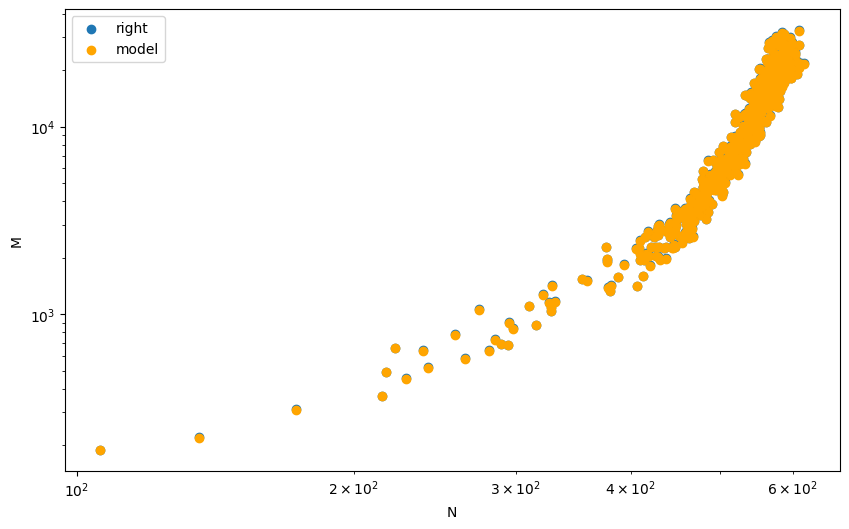

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(active_node_list_left, edge_list_left, label="right")
plt.scatter(active_node_list_left, M_fit,label="model", color="orange")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


In [13]:
# 正規化する
node_norm = active_node_list_left - min(active_node_list_left) + 2
edge_norm = edge_list_left - min(edge_list_left) + 1

In [14]:
max(node_norm)

514

In [15]:
def model_beta_norm(x, alpha, beta):
    Np = 514
    # alphaとbetaは必ず正の値をとる
    if alpha <= 0 or beta <= 0:
        alpha, beta = 0.01, 0.01
    f = lambda a: (((a**(alpha-1)) * ((1-a)**(beta-1))) / random.betavariate(alpha, beta) ) * (1 - ((((alpha + beta)) * (2*a*x[0]) ) / (alpha*Np**2 - alpha*Np)) )**(Np - 1)
    ff, _ = integrate.fixed_quad(f, 0, 1)  # 積分の値と推定誤差を別々に受け取る
    func = Np * (1 - ff) 
    return func

In [16]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

params, _ = optimize.curve_fit(model_beta_norm, xdata=edge_norm, ydata=node_norm)

print("alpha: ", params[0])
print("beta: ", params[1])

+------------------+
| Estimating       |
+------------------+
alpha:  1.0000000489848477
beta:  0.99999997011807


In [17]:
Np = max(node_norm)
alpha = params[0]
beta = params[1]

Nnorm_fit = []
for i in range(len(edge_norm)):
    Nnorm_fit.append(model_beta([edge_norm[i]], alpha, beta))

Mnorm_fit = []
for i in range(len(kappa)):
    Mnorm_fit.append(((kappa[i] * (Np ** 2)) - (kappa[i] * Np)) / 8)

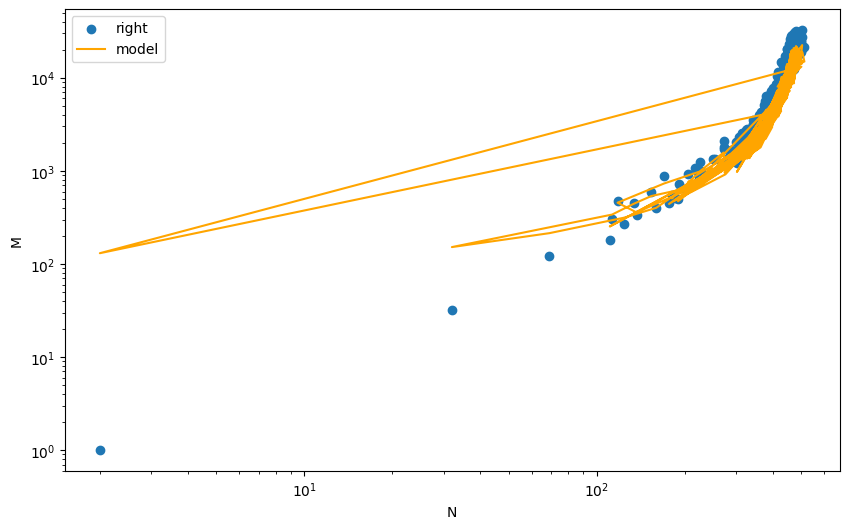

In [18]:
plt.figure(figsize=(10, 6))
# plt.scatter(node_left, edge_left, label="left")
plt.scatter(node_norm, edge_norm, label="right")
plt.plot(node_norm, Mnorm_fit,label="model", color="orange")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()
